# What We Saw from Satellite-Retrieved Snow Cover Data

In this demo we are going to show snow cover data one week before Christmas eve using __[MODIS/Terra Snow Cover Daily L3 Global, Version 6](http://data.planetos.com/datasets/nsidc_modis_snow_cover_global)__ dataset. 

This dataset reports the percentage of snow-covered land in 0.05° (approx. 5 km) resolution Climate Modeling Grid (CMG) cells. Percentages are computed from snow cover observations in the MODIS/Terra Snow Cover Daily L3 Global 500m Grid (MOD10A1) dataset. Cloud cover percentages are also provided. 

We are going to use _daily snow extent_ variable and we will be looking at the Northern part of the globe, from latitude 10N to 71N. 

__[MODIS](https://modis.gsfc.nasa.gov/about/)__  (Moderate Resolution Imaging Spectroradiometer) is a key instrument aboard the Terra and Aqua satellites. Terra's orbit around the Earth is timed so that it passes from north to south across the equator in the morning, while Aqua passes south to north over the equator in the afternoon. Terra MODIS and Aqua MODIS are viewing the entire Earth's surface every 1 to 2 days, acquiring data in 36 spectral bands. 

As MODIS uses visible light from Earth, data is not collected during the night. Also, clouds are influencing the results. In this dataset there are some values that are referring to different kind of conditions. We have created a map to illustrate why there is no data collected from some of these places.

In this demo we will:

1) use the Planet OS package API to fetch data;

2) show snow cover map from one week before Christmas 2018;

3) show map with masked value meanings.

In [1]:
%matplotlib notebook
import numpy as np
from dh_py_access import package_api
import dh_py_access.lib.datahub as datahub
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
from matplotlib import colors
import warnings
warnings.filterwarnings("ignore")
mpl.rcParams['font.family'] = 'Avenir Lt Std'

<font color='red'>Please put your datahub API key into a file called APIKEY and place it to the notebook folder or assign your API key directly to the variable API_key!</font>

In [2]:
server = 'api.planetos.com'
API_key = open('APIKEY').readlines()[0].strip() #'<YOUR API KEY HERE>'
version = 'v1'

At first, we need to define the dataset name and a variable we want to use.

In [3]:
dh=datahub.datahub(server,version,API_key)
dataset='nsidc_modis_snow_cover_global'
variable_name1 = 'Day_CMG_Snow_Cover'
time_start = '2018-12-18T00:00:00'
time_end = '2018-12-18T23:00:00'

In [4]:
time_start2 = '2017-12-24T00:00:00'
time_end2 = '2017-12-24T23:00:00'

Then we define spatial range. At this time, we will look into Northern Hemisphere from 10N to 71N. 

In [5]:
area_name = 'north'
latitude_north = 71; longitude_west = -160
latitude_south = 10; longitude_east = 180

### Download the data with package API

1. Create package objects
2. Send commands for the package creation
3. Download the package files

In [6]:
package = package_api.package_api(dh,dataset,variable_name1,longitude_west,longitude_east,latitude_south,latitude_north,time_start,time_end,area_name=area_name)
package2 = package_api.package_api(dh,dataset,variable_name1,longitude_west,longitude_east,latitude_south,latitude_north,time_start2,time_end2,area_name=area_name)

In [7]:
package.make_package()
package2.make_package()

Package exists
Package exists


In [8]:
package.download_package()
package2.download_package()

File already downloaded


### Work with downloaded files

We start by opening the files with xarray and by making the data column names _masked_snow_cover_. At first, we will have the same data as _Day_CMG_Snow_Cover_, but later, we will mask out values that are explained under the _Day_CMG_Snow_Cover Key_ attribute.

In [9]:
dd1 = xr.open_dataset(package.local_file_name)
dd1['masked_snow_cover'] = dd1.Day_CMG_Snow_Cover
dd2 = xr.open_dataset(package2.local_file_name)
dd2['masked_snow_cover'] = dd2.Day_CMG_Snow_Cover

Here we are finding the mask values and we will print them out. However, we will ingnore the data values. 

In [10]:
masks = dd1.Day_CMG_Snow_Cover.Key.split(',')
print (masks)
masks = masks[1:]

masks2 = dd2.Day_CMG_Snow_Cover.Key.split(',')
masks2 = masks2[1:]

['0-100=percent of snow in cell', ' 107=lake ice', ' 111=night', ' 237=inland water', ' 239=ocean', ' 250=cloud obscured water', ' 253=data not mapped', ' 255=fill']


In [11]:
for imask,mask in enumerate(masks):
    mask_value = float(mask[:4])
    mask_value2 = float(masks2[imask][:4])
    dd1['masked_snow_cover'].data = np.ma.masked_where(dd1['masked_snow_cover'].data == mask_value,dd1['masked_snow_cover'].data)
    dd2['masked_snow_cover'].data = np.ma.masked_where(dd2['masked_snow_cover'].data == mask_value,dd2['masked_snow_cover'].data)

Now we are making Basemap of the area on what we will show the data.

In [12]:
m_demo=Basemap(projection='merc',llcrnrlat=latitude_south,urcrnrlat=latitude_north,\
            llcrnrlon=-160,urcrnrlon=longitude_east,lat_ts=(latitude_north+latitude_south)/2,resolution='l')
Dx,Dy = np.meshgrid(dd1.lon.data,dd1.lat.data)
dx,dy = m_demo(Dx,Dy)

Then it is time to plot all the data,so that we can see where the snow occured during December 18th. However, we will  not able to see the data from some of the locations in the North. Reasons to why are explained below.

On this map, we can see that Canada had plenty of snow week before Christmas, also some places in the North of US, mostly in the mountains. While in Europe Alps have the most snow. Also Norway, Sweden, Finland and Estonia have some. Unfortunately we can't see data from Lapland, which definately have a lot snow, because of the polar night. We can see that many Europe countries don't have persistent snow cover, but some parts still have a little snow. The eastern part of the world, especially Russia also have snow.

If you want to have closer look, you can use tools below the map to zoom in. We definitely encourage you to try that.

<IPython.core.display.Javascript object>


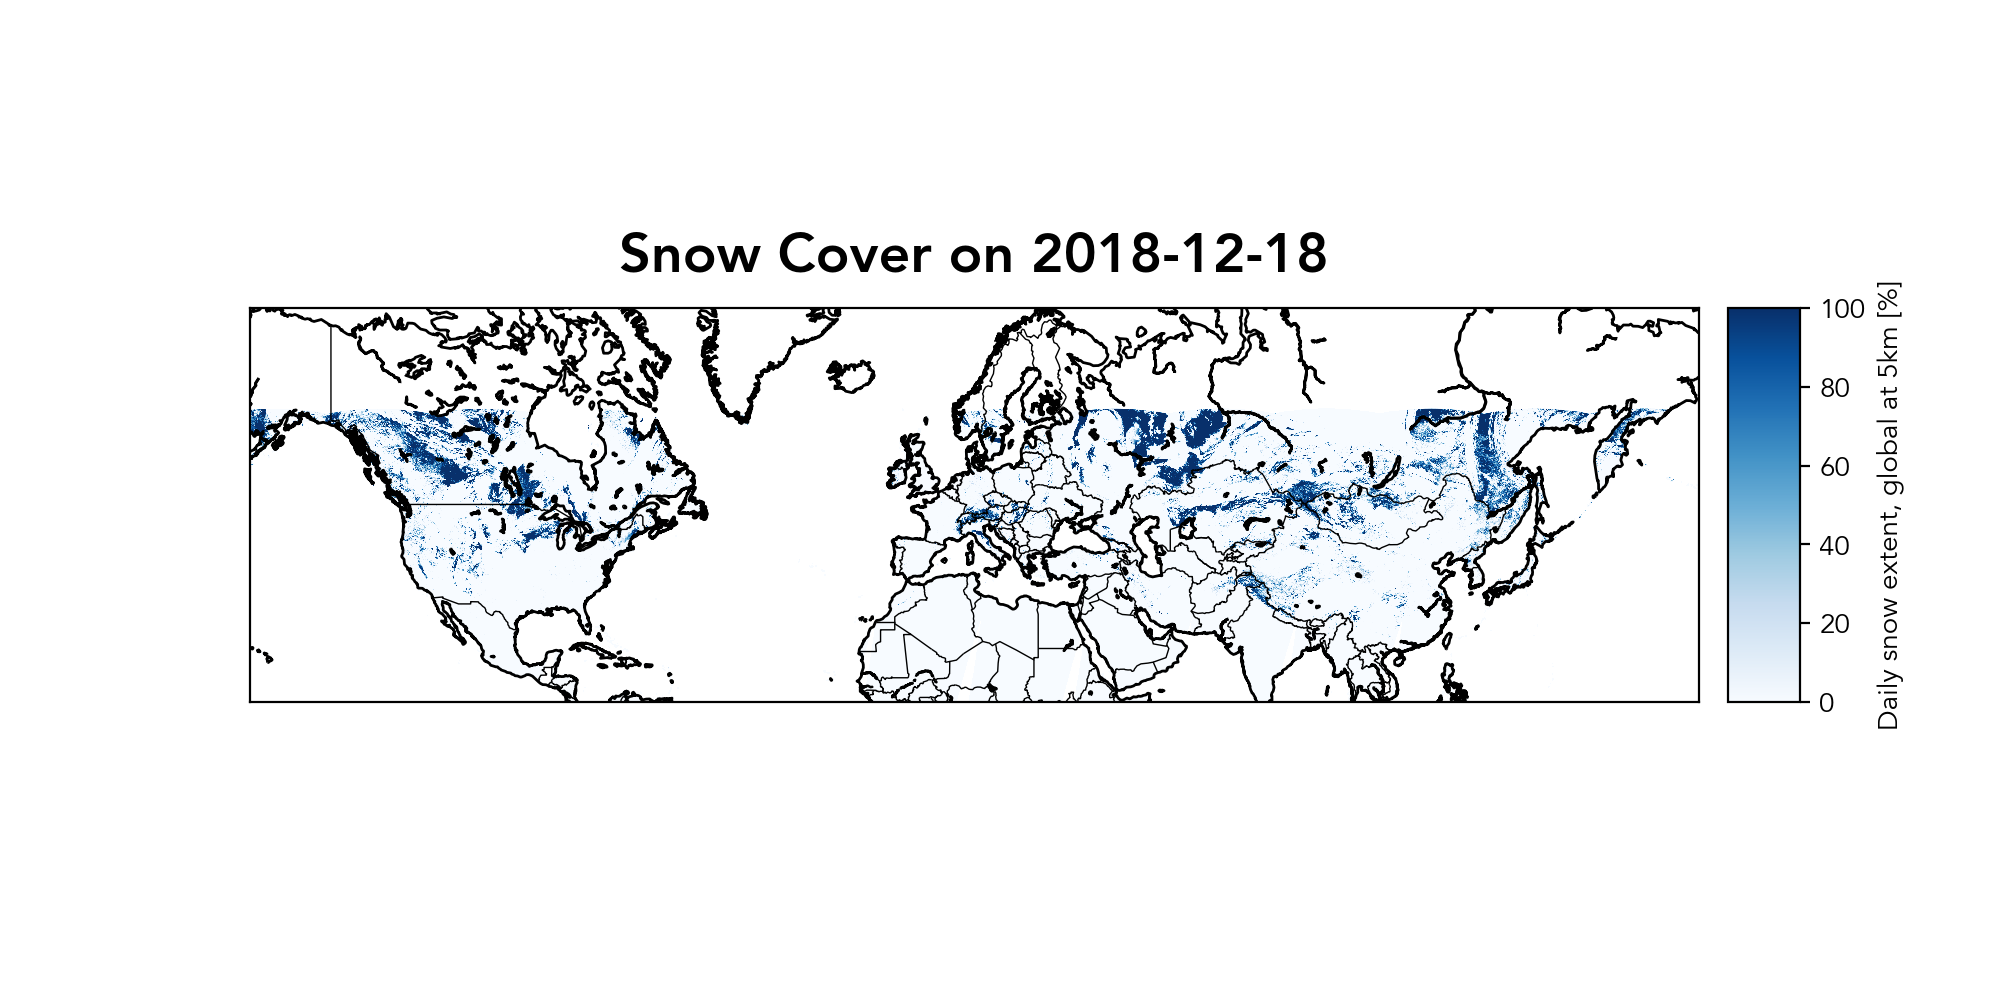

In [13]:
fig=plt.figure(figsize=(10,5))
mp = m_demo.pcolormesh(dx,dy,dd1['masked_snow_cover'].data[0,:,:],vmin=0,vmax=100,cmap = 'Blues')
m_demo.colorbar(mp,label = dd1.Day_CMG_Snow_Cover.long_name + '[' + dd1.Day_CMG_Snow_Cover.units + ']')
ttl = plt.title('Snow Cover on ' + str(dd1.time.values[0])[:-19],fontsize=20,fontweight = 'bold')
ttl.set_position([.5, 1.05])
m_demo.drawcoastlines()
m_demo.drawcountries()

For comparisson, we add a snow cover data from last Christmas. We can see how snow coverage in North America is a bit different. Eastern part of the world has more snow this year than last Christmas. 

<IPython.core.display.Javascript object>


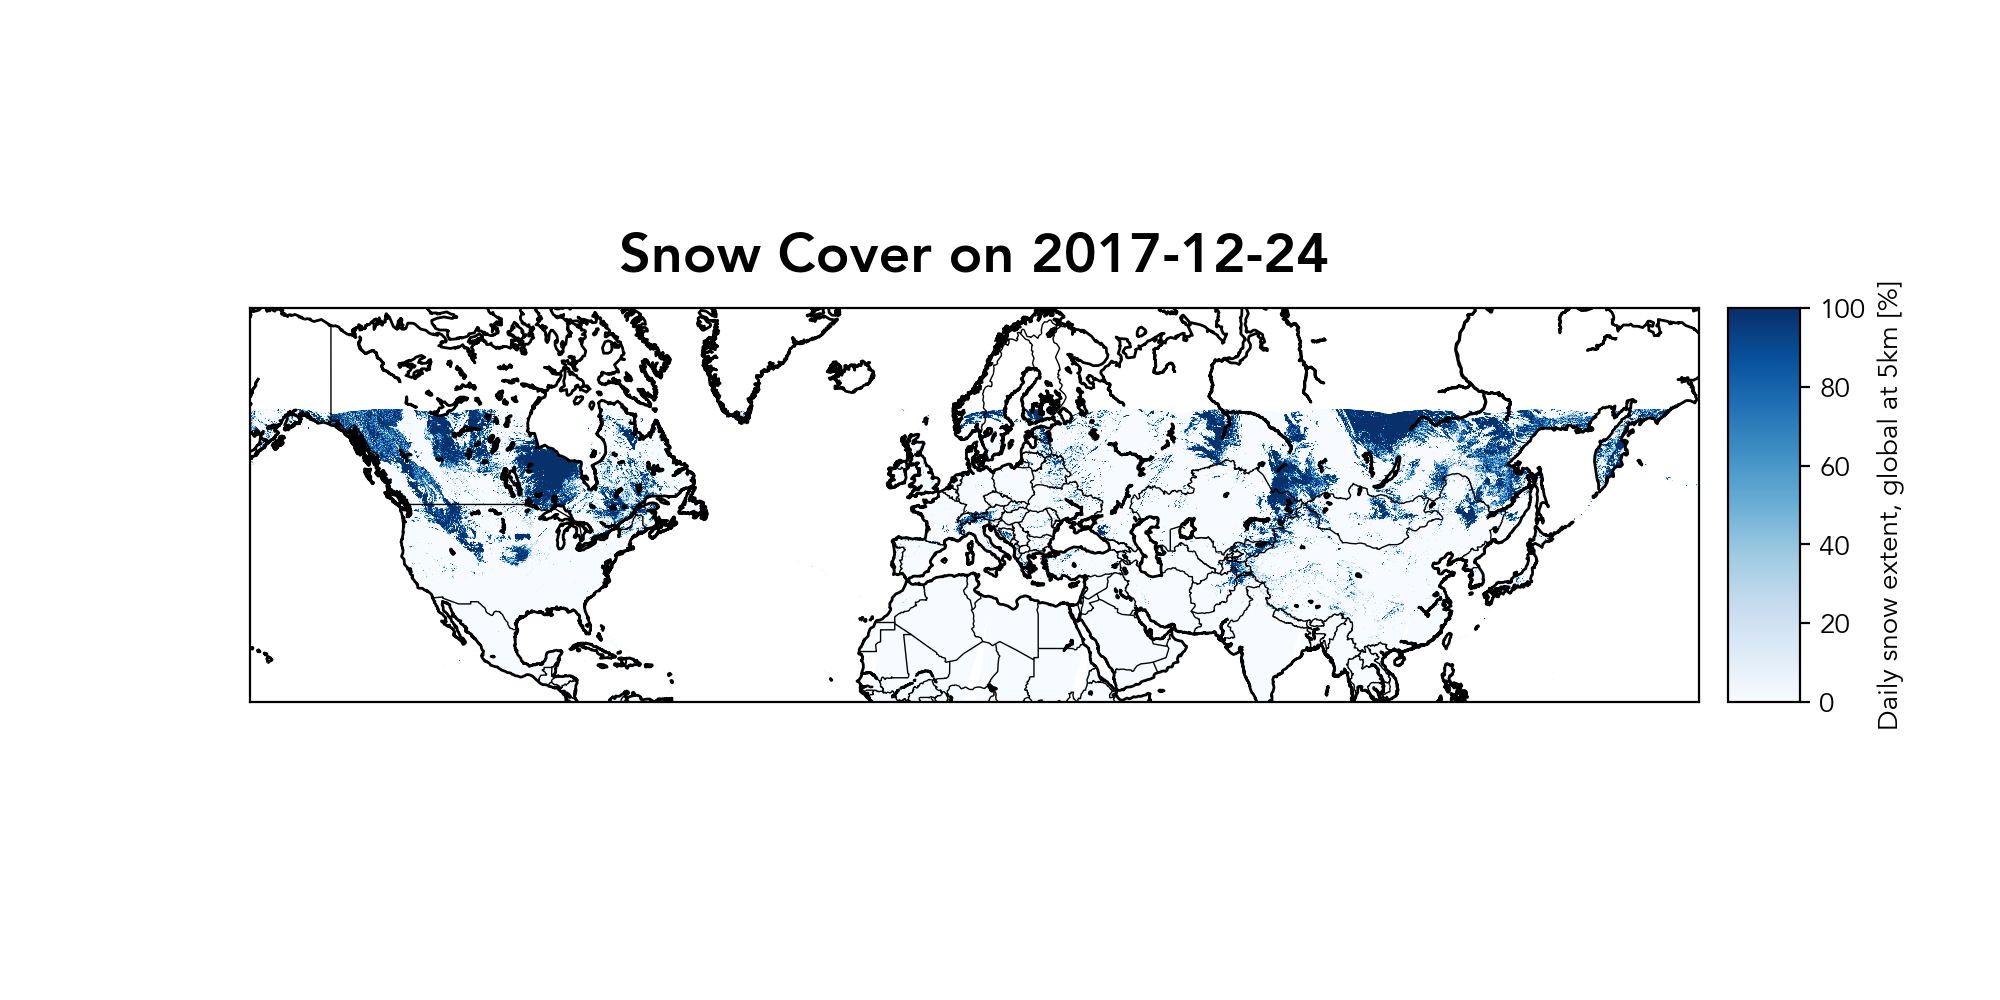

In [14]:
fig=plt.figure(figsize=(10,5))
mp = m_demo.pcolormesh(dx,dy,dd2['masked_snow_cover'].data[0,:,:],vmin=0,vmax=100,cmap = 'Blues')
m_demo.colorbar(mp,label = dd2.Day_CMG_Snow_Cover.long_name + '[' + dd2.Day_CMG_Snow_Cover.units + ']')
ttl = plt.title('Snow Cover on ' + str(dd2.time.values[0])[:-19],fontsize=20,fontweight = 'bold')
ttl.set_position([.5, 1.05])
m_demo.drawcoastlines()
m_demo.drawcountries()

In [15]:
m_demo2=Basemap(projection='merc',llcrnrlat=43,urcrnrlat=49,\
            llcrnrlon=5.8,urcrnrlon=15.1,lat_ts=(43+49)/2,resolution='l')
Dx2,Dy2 = np.meshgrid(dd1.lon.data,dd1.lat.data)
dx2,dy2 = m_demo2(Dx2,Dy2)

We also wanted to compare Alps snow cover one week prior Christmas with last Christmas as the Europe's biggest ski resorts are there. We can see that snow coverage is quite similar with last year.

<IPython.core.display.Javascript object>


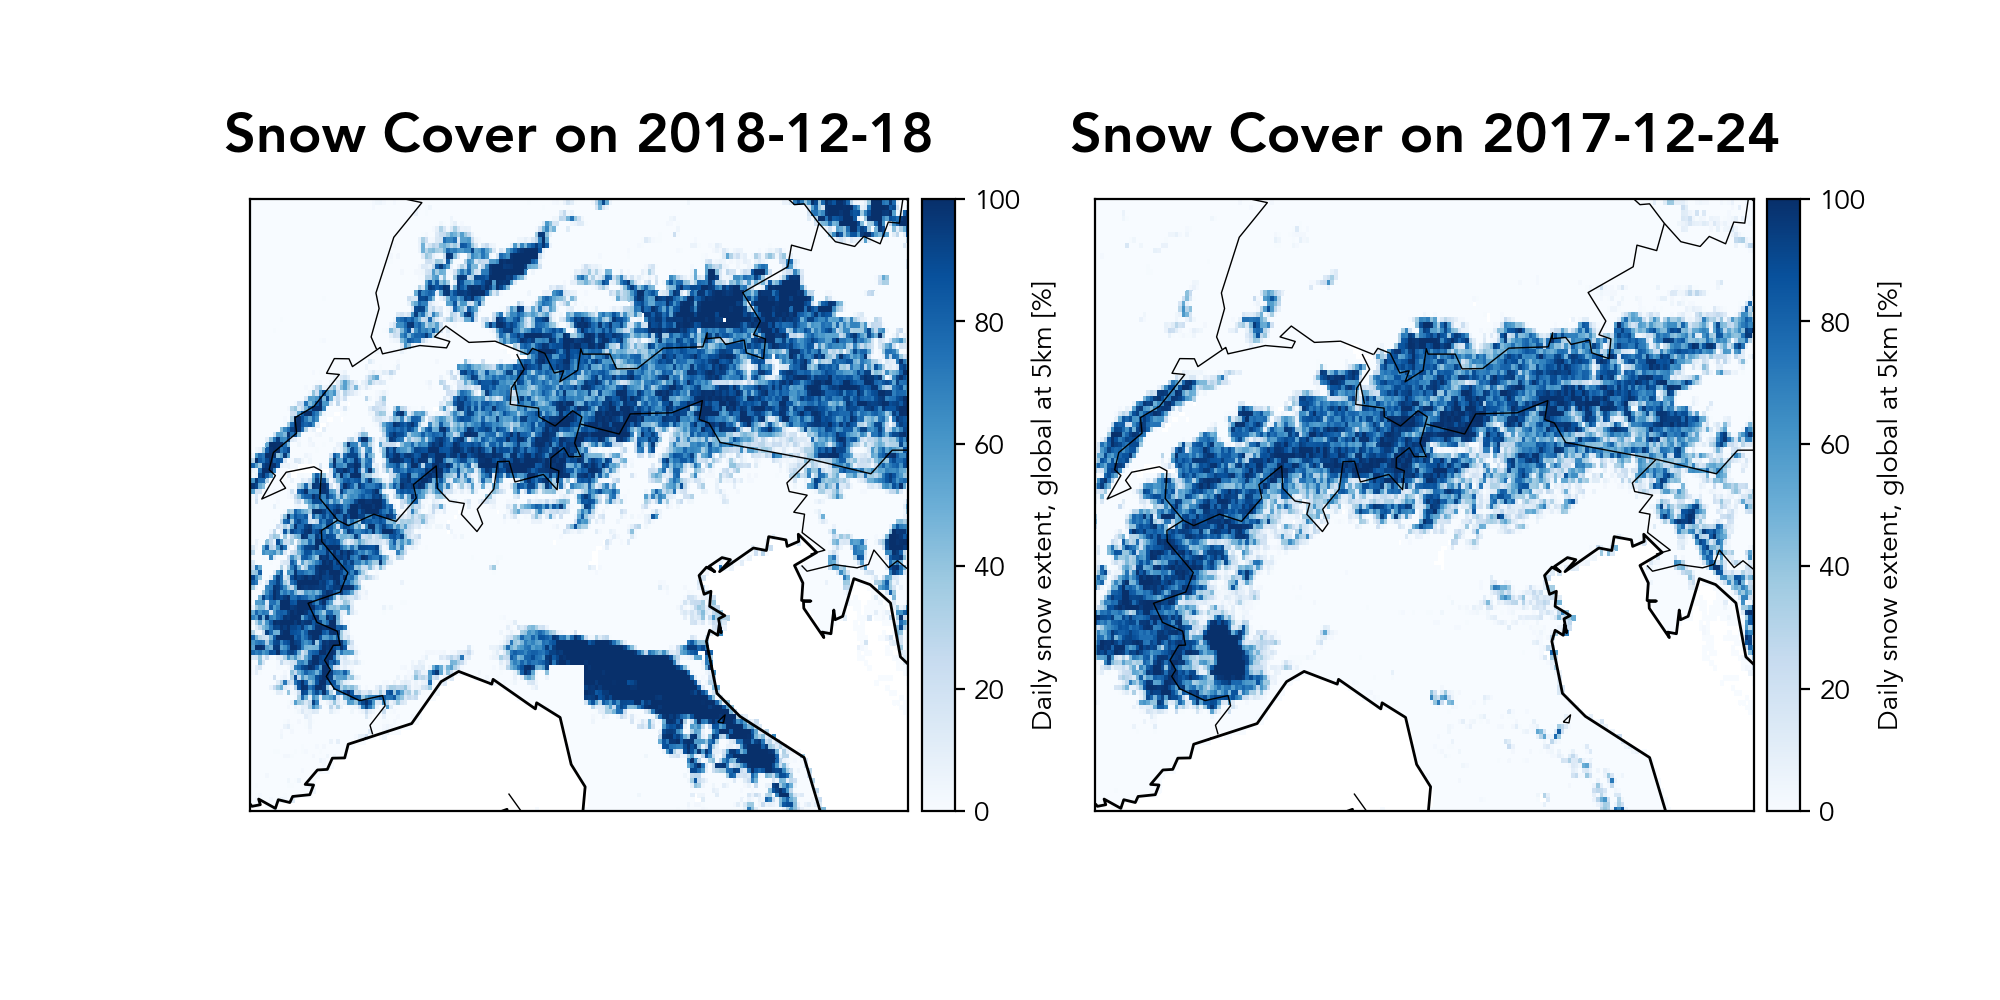

In [16]:
fig=plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
mp = m_demo2.pcolormesh(dx2,dy2,dd1['masked_snow_cover'].data[0,:,:],vmin=0,vmax=100,cmap = 'Blues')
m_demo2.colorbar(mp,label = dd1.Day_CMG_Snow_Cover.long_name + '[' + dd1.Day_CMG_Snow_Cover.units + ']')
ttl = plt.title('Snow Cover on ' + str(dd1.time.values[0])[:-19],fontsize=20,fontweight = 'bold')
ttl.set_position([.5, 1.05])
m_demo2.drawcoastlines()
m_demo2.drawcountries()

ax2 = fig.add_subplot(122)
mp = m_demo2.pcolormesh(dx2,dy2,dd2['masked_snow_cover'].data[0,:,:],vmin=0,vmax=100,cmap = 'Blues')
m_demo2.colorbar(mp,label = dd2.Day_CMG_Snow_Cover.long_name + '[' + dd2.Day_CMG_Snow_Cover.units + ']')
ttl = plt.title('Snow Cover on ' + str(dd2.time.values[0])[:-19],fontsize=20,fontweight = 'bold')
ttl.set_position([.5, 1.05])
m_demo2.drawcoastlines()
m_demo2.drawcountries()
plt.savefig('winter_alps.png',bbox_inches='tight')

As we briefly explained above we couldn't show data for some of the places. We will now create a map that highlights these places. For doing that we need to get rid off the real values and also make _fill values_ back to 255 as they occur as the NaN at the moment.

In [17]:
masked_values = dd1.Day_CMG_Snow_Cover.data[0,:,:]
masked_values = np.ma.masked_where(masked_values < 101,masked_values)
masked_values[np.isnan(masked_values)] = 255

On the new map below we can see that in some of the northern parts there is no data because MODIS instrument requires sunlight to operate (it's like a digital camera in many respects). During Christmas time most of that region has a polar night or very little daylight. Therefore, the data about snow can't be shown. In some places between 10N to 29N latitude, the data wasn't mapped, because those areas were out of the __[sensor range](https://sos.noaa.gov/ftp_mirror/rt/modis/media/thumbnail_big.jpg)__ .

<IPython.core.display.Javascript object>


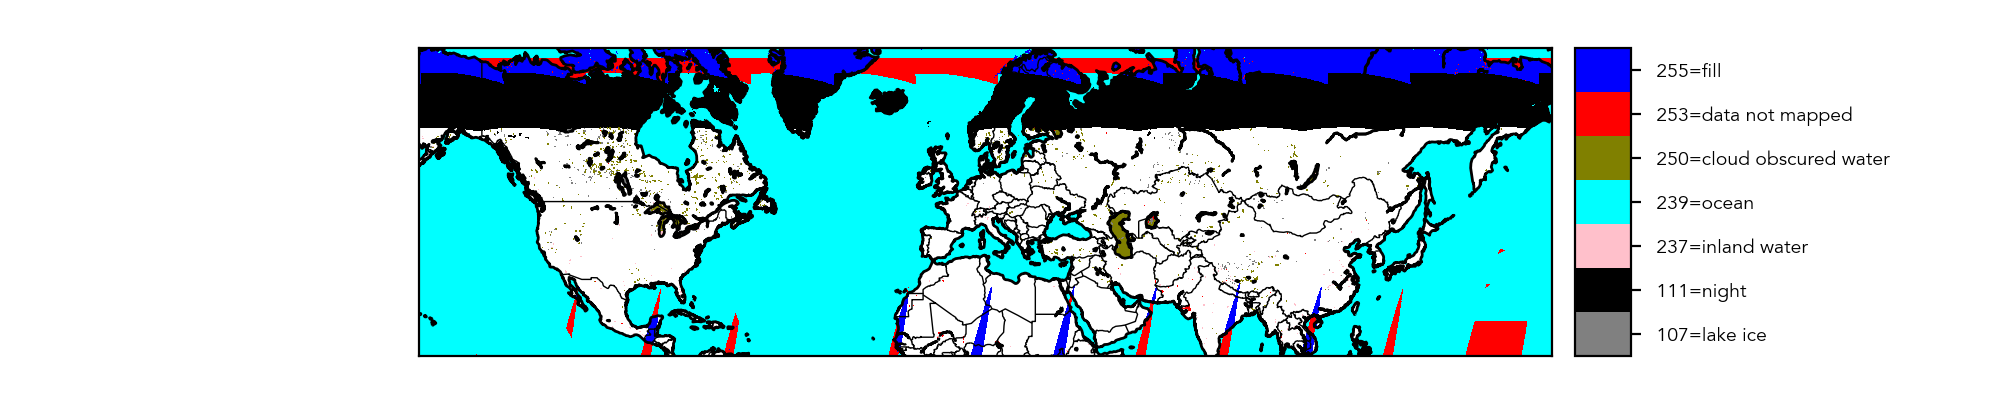

In [18]:
#107=lake ice', ' 111=night', ' 237=inland water', ' 239=ocean', ' 250=cloud obscured water', ' 253=data not mapped', ' 255=fill'
fig=plt.figure(figsize=(10,2))
cmap = colors.ListedColormap(['grey','black','pink','cyan','olive','red','blue'])
bounds = [106,108,112,238,240,251,254,256]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
d = m_demo.pcolormesh(dx,dy,masked_values,cmap=cmap, norm=norm)
cbar = m_demo.colorbar(d,ticks=[107,110,175,239,245.5,252.5,255])
cbar.ax.tick_params(labelsize=7) 
cbar.ax.set_yticklabels(masks) 
m_demo.drawcoastlines()
m_demo.drawcountries()
plt.show()